In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F          
from torch.utils.data import DataLoader  
from torch.utils.data import Subset      
from torchvision import datasets, transforms
from torchsummary import summary
import torchvision.models as models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Data loading
train_data_dir = r'C:\Users\computer\Desktop\chest\train'
test_data_dir = r'C:\Users\computer\Desktop\chest\test'

# Training transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adds color variation
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), 
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Testing transformations (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Load the training dataset with training transforms
train_dataset = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
trainloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Load the testing dataset with testing transforms
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)
testloader = DataLoader(test_dataset, batch_size=8, shuffle=False)


# Number of classes
num_classes = len(train_dataset.classes)
print (f'Number of class: {num_classes}')
class_names = train_dataset.classes
print (f'Name of class: {class_names}')
print (f'Train dataset:{len(train_dataset)}')
print (f'Test dataset:{len(test_dataset)}')

# Dataloaders dictionary
dataloaders = {
    'train': trainloader,
    'val': testloader  # Using testloader as validation set
}

Number of class: 2
Name of class: ['NORMAL', 'PNEUMONIA']
Train dataset:5216
Test dataset:624


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
model = models.resnet18(pretrained=True)

#Freeze the first five layers
#Layer 1: Initial convolutional layer
for param in model.conv1.parameters():
    param.requires_grad = False

# Freeze layers 2-7
layers_to_freeze = [
    model.layer1[0],  # Layer 2
    model.layer1[1],  # Layer 3
    model.layer2[0],  # Layer 4
    model.layer2[1],  # Layer 5
    model.layer3[0],  # Layer 6
    model.layer3[1],  # Layer 7
]

for layer in layers_to_freeze:
    for param in layer.parameters():
        param.requires_grad = False

#Check if freezing was successful
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

#The rest of the model remains trainable (layers 6–10)
#Move the model to the device (e.g., GPU if available)


conv1.weight: requires_grad=False
bn1.weight: requires_grad=True
bn1.bias: requires_grad=True
layer1.0.conv1.weight: requires_grad=False
layer1.0.bn1.weight: requires_grad=False
layer1.0.bn1.bias: requires_grad=False
layer1.0.conv2.weight: requires_grad=False
layer1.0.bn2.weight: requires_grad=False
layer1.0.bn2.bias: requires_grad=False
layer1.1.conv1.weight: requires_grad=False
layer1.1.bn1.weight: requires_grad=False
layer1.1.bn1.bias: requires_grad=False
layer1.1.conv2.weight: requires_grad=False
layer1.1.bn2.weight: requires_grad=False
layer1.1.bn2.bias: requires_grad=False
layer2.0.conv1.weight: requires_grad=False
layer2.0.bn1.weight: requires_grad=False
layer2.0.bn1.bias: requires_grad=False
layer2.0.conv2.weight: requires_grad=False
layer2.0.bn2.weight: requires_grad=False
layer2.0.bn2.bias: requires_grad=False
layer2.0.downsample.0.weight: requires_grad=False
layer2.0.downsample.1.weight: requires_grad=False
layer2.0.downsample.1.bias: requires_grad=False
layer2.1.conv1.weigh

C:\Users\computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\computer\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
model.fc = nn.Linear(model.fc.in_features, 2)  # For 'NORMAL' and 'PNEUMONIA' classes
model = model.to(device)
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # L2 regularization
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [6]:
# Initialize the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Adjust every 5 epochs

In [7]:
def training(model, dataloaders, criterion, optimizer, num_epochs):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    val_acc_history = []
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Start timing the epoch
        start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Store history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())

                # Deep copy the model if it has the best accuracy
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
        # Step the learning rate scheduler
        scheduler.step()

        # End timing the epoch
        end_time = time.time()
        epoch_duration = end_time - start_time
        print(f'Epoch {epoch + 1} duration: {epoch_duration:.2f} seconds')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_loss_history, train_acc_history, val_loss_history


In [8]:
# Run the training
num_epochs = 50  # Set your number of epochs
best_model, val_acc_history, train_loss_history, train_acc_history, val_loss_history = training(model, dataloaders, criterion, optimizer, num_epochs)

Epoch 1/50
----------
train Loss: 0.2186 Acc: 0.9170
val Loss: 0.2780 Acc: 0.9183
Epoch 1 duration: 109.40 seconds
Epoch 2/50
----------
train Loss: 0.1376 Acc: 0.9457
val Loss: 0.5834 Acc: 0.8782
Epoch 2 duration: 111.70 seconds
Epoch 3/50
----------
train Loss: 0.1191 Acc: 0.9572
val Loss: 0.2139 Acc: 0.9311
Epoch 3 duration: 112.20 seconds
Epoch 4/50
----------
train Loss: 0.1127 Acc: 0.9595
val Loss: 0.3240 Acc: 0.9038
Epoch 4 duration: 111.84 seconds
Epoch 5/50
----------
train Loss: 0.1184 Acc: 0.9582
val Loss: 0.2361 Acc: 0.9279
Epoch 5 duration: 111.71 seconds
Epoch 6/50
----------
train Loss: 0.0991 Acc: 0.9641
val Loss: 0.2550 Acc: 0.9247
Epoch 6 duration: 111.87 seconds
Epoch 7/50
----------
train Loss: 0.1045 Acc: 0.9613
val Loss: 0.3900 Acc: 0.9054
Epoch 7 duration: 111.73 seconds
Epoch 8/50
----------
train Loss: 0.1001 Acc: 0.9626
val Loss: 0.2477 Acc: 0.9183
Epoch 8 duration: 111.50 seconds
Epoch 9/50
----------
train Loss: 0.0904 Acc: 0.9655
val Loss: 0.2127 Acc: 0.924

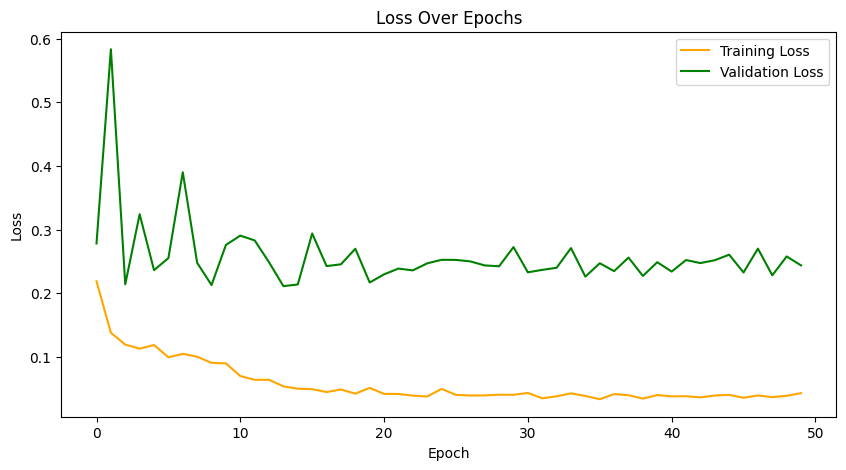

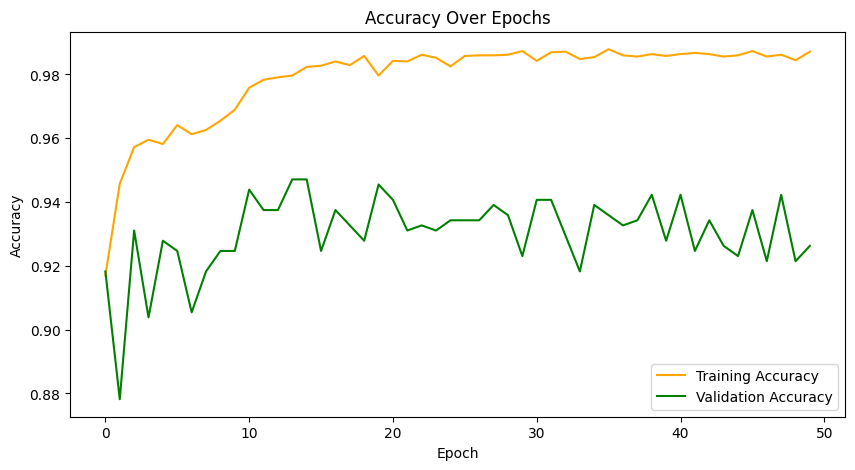

In [9]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss', color='orange')
plt.plot(val_loss_history, label='Validation Loss', color='green')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label='Training Accuracy', color='orange')
plt.plot(val_acc_history, label='Validation Accuracy', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()